# Notebook  6 - Simulazione Modello di Ising

Questa lezione contiene una simulazione del modello di Ising, che consiste in una spiegazione del ferromagnetismo attraverso lo spin degli atomi. La simulazione è stata svolta per un sistema monodimensionale di $N=50$ spin, sfruttando gli algoritmi di Metropolis e Gibbs.

   - [  6.1 - Termalizzazione ](#ex-6.1) 
   
   - [  6.2 - Misura delle Proprietà ](#ex-6.2)
   
   - [  6.3 - Simulazione del Sistema ](#ex-6.3)

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as mpl

### Descrizione del sistema
Il modello di Ising venne introdotto per fornire una spiegazione quantitativa del ferromagnetismo. Il sistema a cui si è applica è quello di un reticolo $N$-dimensionale di particelle dotate di spin $\pm 1$. Ad oggi, il modello di Ising è stato risolto analiticamente solo in una e due dimensioni, e in questo notebook viene trattato quello monodimensionale </br>
Secondo il modello, l'energia del sistema è fornita dall'Hamiltoniana:

\begin{equation}
H = -J \sum_{i}s_i s_{i+1} - h\sum_{i}s_i
\end{equation}

Dove $J$ rappresenta l'intensità di interazione tra due spin adiacenti e $h$ quella tra uno spin e il campo esterno. L'Hamiltoniana esprime il fatto che l'energia del sistema dipende fortemente dall'accoppiamento tra spin adiacenti, che tendono ad allinearsi. L'energia del sistema è minima quando tutti gli spin sono allineati, e in questa situazione si dice che il sistema è <b> magnetizzato </b>. Questa tendenza degli spin ad allinearsi viene ostacolata dalle oscillazioni del sistema, che tendono a ribaltare gli spin in maniera randomica. Queste due opposte tendenze vengono mostrate nella sezione [6.3](#ex-6.3) di questo notebook. </br>
L'obiettivo della simulazione è calcolare le seguenti quantità in funzione di T nell'intervallo $[0.2, 3]$:
- Energia Interna: $U(N,T) = \langle H \rangle$
- Capacità Termica: $C(N,T) = k_B \beta^2 (\langle H^2 \rangle - \langle H \rangle^2)$
- Suscettività Magnetica: $\chi(N,T) = \beta \langle (\sum s_i)^2 \rangle $
- Magnetizzazione: $M(N,N,h) = \langle \sum s_i \rangle $

Esprimere rispetto a T le quantità è possibile grazie al fatto che l'algoritmo operi a temperatura costante, ovvero nell'<b> ensemble canonico </b>, all'interno del quale gli stati (costituiti dal una precisa combinazione dei 50 spin) seguono il <b> peso di Boltzmann </b>:

\begin{equation}
 P({s_i}) = \frac{\exp(-\beta H)}{Z}
\end{equation}


### Descrizione del codice
Il ruolo fondamentale degli algoritmi di Metropolis e Gibbs sarà proprio quello di campionare il peso di Boltzmann, in modo tale da evolvere il sistema mantenendosi sempre all'interno dell'ensemble canonico. Essi agiscono nel seguente modo:
- <b> Metropolis </b>: A partire da una configurazione iniziale di spin, viene modificata casualmente l'orientazione di uno spin selezionato anch'esso casualmente. Se la mossa porta il sistema in una configurazione di energia più bassa (e quindi più probabile), viene automaticamente accettata, mentre le mosse verso configurazioni meno probabili vengono rigettate solo in parte. 
- <b> Gibbs </b>: A partire da una configurazione di spin, viene selezionato uno spin casualmente e viene riestratto, indipendentemente da quelli adiacenti. Se la nuova configurazione è energeticamente convieniente, lo spin viene flippato. In caso contrario, viene imposta la mossa contraria. Per il fatto di imporre sempre una mossa, l'algoritmo di Gibbs è più rapido.

Il codice è strutturato nella seguente maniera:
- `Input()`: funzione che inizializza il sistema, prendendo da file i dati necessari e le modalità. Sono state aggiunti due parametri, `restart` che permette di ricominciare la simulazione da una configurazione precedente, e `config`, che permette di far partire il sistema da spin casuali o allineati.
- `Move()`: funzione che effettua l'operazione di flip degli spin, secondo Metropolis o Gibbs.
- `Measure()` e `Accumulate()`: funzioni che calcolano i risultati, in particolare è stato usato il data blocking per ottenere risultati migliori e meno correlati.


<a id="ex-6.1"></a>
## Esercizio 6.1. - Termalizzazione
Prima di procedere con il calcolo vero e proprio delle quantità, è necessario analizzare se il sistema ha bisogno di essere termalizzato. Per questo motivo il sistema è stato fatto evolvere liberamente per $2000$ passi, studiandone le oscillazioni di energia interna. </br>
Questo procedimento è stato svolto con entrambi i metodi (Metropolis e Gibbs), sia partendo da spin casuali che partendo da spin allineati. Si può notare che la termalizzazione viene raggiunta rapidamente in tutti i casi, senza che sia necessario aspettare un determinato numero di mosse. </br>
Per rispettare comunque una minima equilibrazione del sistema, prima di prendere i dati nella sezione successiva, al sistema sono stati fatti fare $2000$ passi "a vuoto", ovvero senza prendere nessun dato. 

In [2]:
import numpy as np

def energy(T):
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN = th**Ns
    ch = 1/th
    e = -J*(th + ch*thN)/(1 + thN)
    return e

def heat(T):
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN = th**Ns
    ch = 1/th
    heat=((beta*J)**2)*(((1+thN+(Ns-1)*(th**2)+(Ns-1)*(ch**2)*thN)/(1+thN))-Ns*((th+ch*thN)/(1+thN))**2)
    return heat

def chi(T):
    beta = 1/T
    J = 1.0
    Ns = 50
    th = np.tanh(J/T)
    thN = th**Ns
    ch = 1/th
    X = beta*np.exp(2*beta*J)*(1-thN)/(1+thN)
    return X

def mag(T):
    h = 0.02
    b = 1/T
    l1 = np.exp(b*J)*np.cosh(b*h)+np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    l2 = np.exp(b*J)*np.cosh(b*h)-np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))
    Z = l1**Ns + l2**Ns
    M = (np.exp(b*J)*np.sinh(b*h)*((l1**(Ns-1))*(1+np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J))) 
        + (l2**(Ns-1))*(1-np.exp(b*J)*np.cosh(b*h)/np.sqrt(np.exp(2*b*J)*np.cosh(b*h)*np.cosh(b*h)-2*np.sinh(2*b*J)))))/(Z)
    return M
    

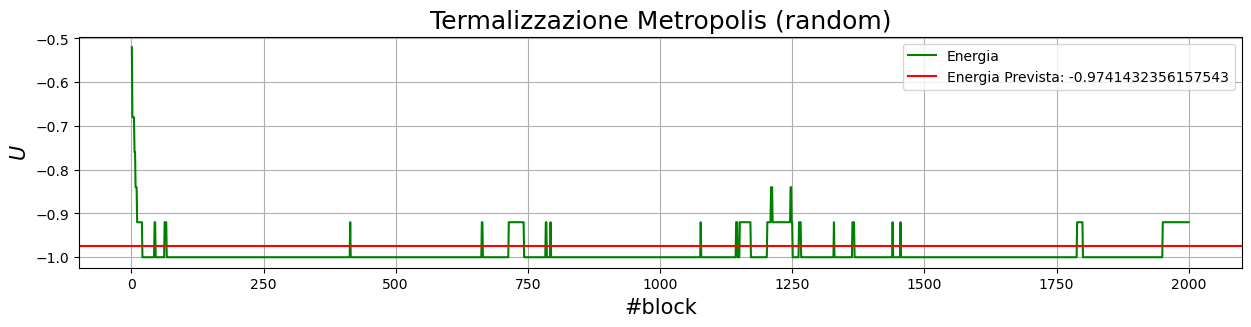

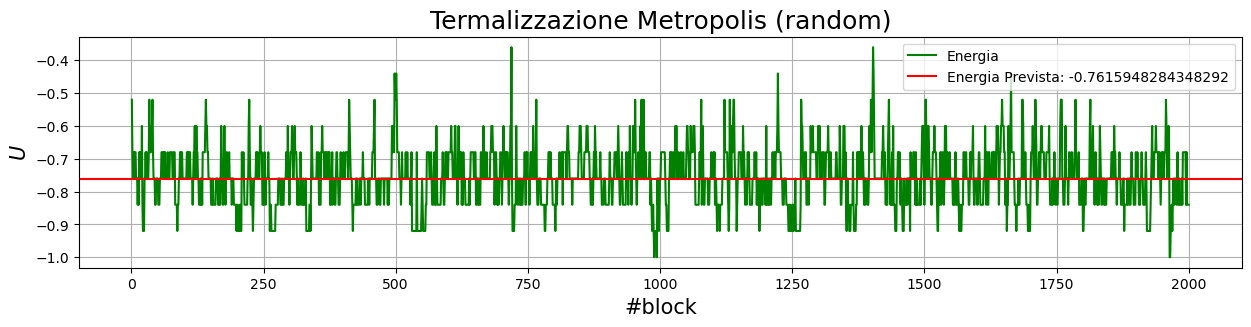

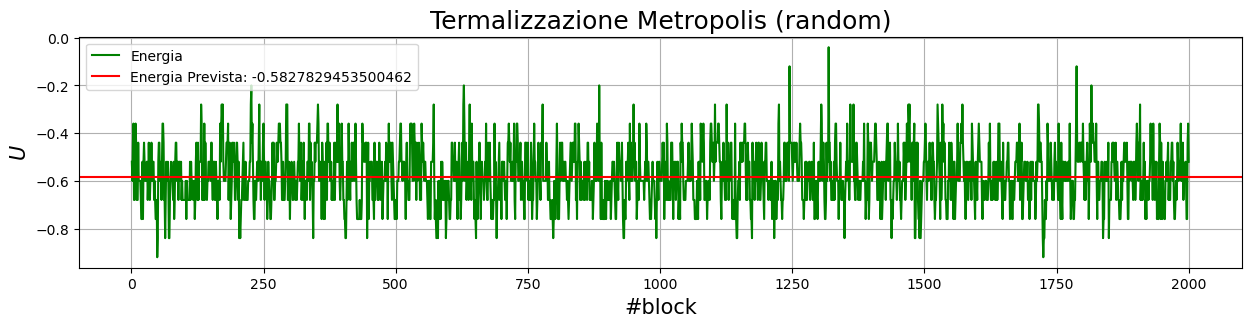

In [3]:
start = ['05', '1', '15']
T = [0.5, 1, 1.5]

for i in range(0,3):
    x, aveT = np.loadtxt("Exercise06-1/output/output_thermal/metro/metro_random_"  + start[i] + ".dat", usecols=(0, 1), delimiter='\t', unpack='true')
    fig, ax = mpl.subplots(figsize=(15, 3))
    ax.plot(x, aveT, marker=None, label="Energia", color="green")
    ax.set_title("Termalizzazione Metropolis (random)", fontsize=18)
    ax.set_ylabel(r'$U$', fontsize=15)
    ax.set_xlabel('#block', fontsize=15)
    ax.axhline(y=energy(T[i]), color="r", label="Energia Prevista: " + str(energy(T[i])))
    ax.grid(True)
    ax.legend()
    mpl.show()

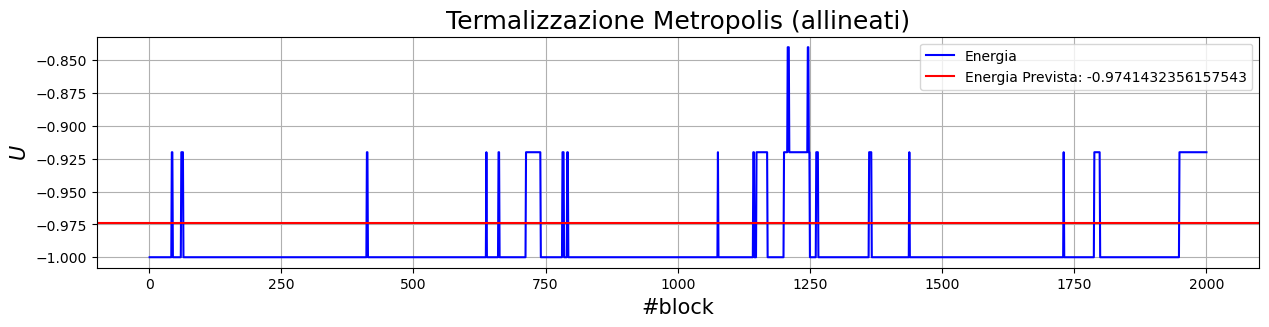

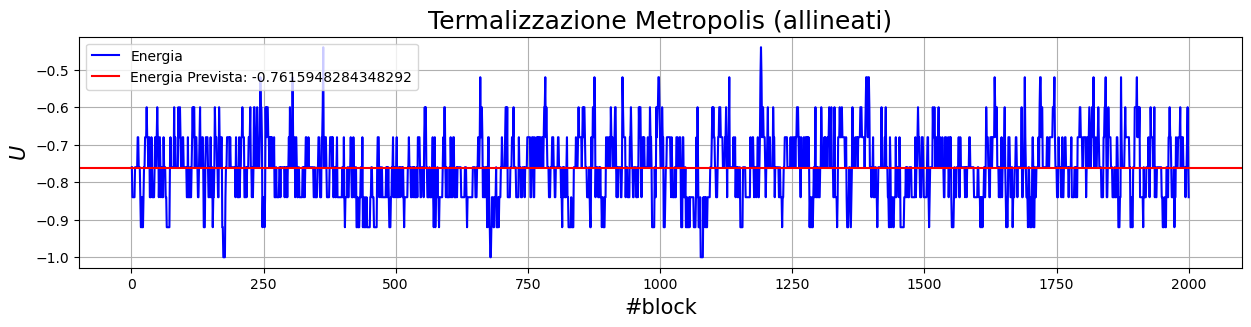

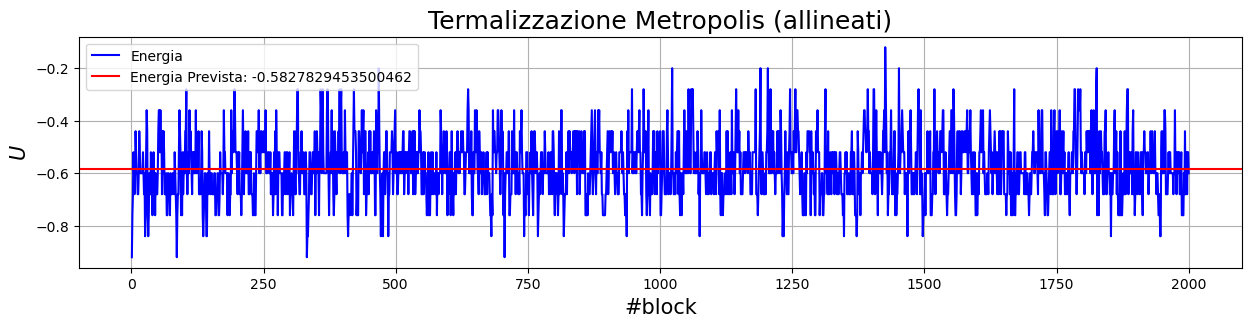

In [4]:
for i in range(0,3):
    x, aveT = np.loadtxt("Exercise06-1/output/output_thermal/metro/metro_align_"  + start[i] + ".dat", usecols=(0, 1), delimiter='\t', unpack='true')
    fig, ax = mpl.subplots(figsize=(15, 3))
    ax.plot(x, aveT, marker=None, label="Energia", color="blue")
    ax.set_title("Termalizzazione Metropolis (allineati)", fontsize=18)
    ax.set_ylabel(r'$U$', fontsize=15)
    ax.set_xlabel('#block', fontsize=15)
    ax.axhline(y=energy(T[i]), color="r", label="Energia Prevista: " + str(energy(T[i])))
    ax.grid(True)
    ax.legend()
    mpl.show()

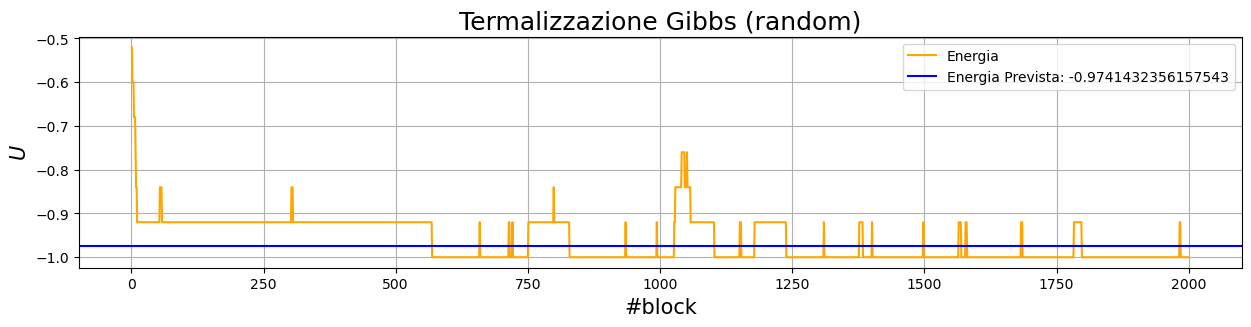

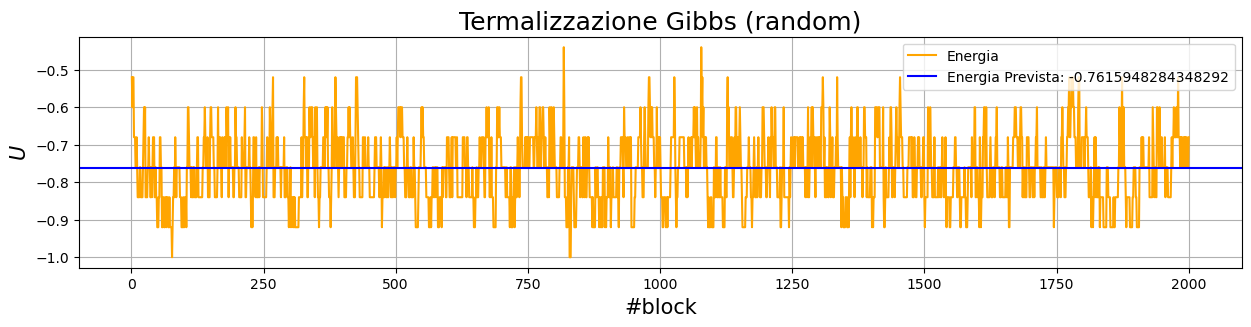

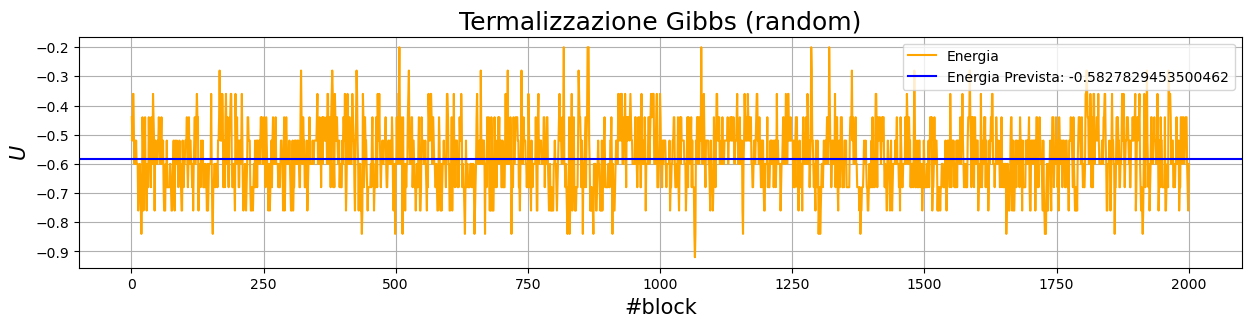

In [5]:
for i in range(0,3):
    x, aveT = np.loadtxt("Exercise06-1/output/output_thermal/gibbs/gibbs_random_"  + start[i] + ".dat", usecols=(0, 1), delimiter='\t', unpack='true')
    fig, ax = mpl.subplots(figsize=(15, 3))
    ax.plot(x, aveT, marker=None, label="Energia", color="orange")
    ax.set_title("Termalizzazione Gibbs (random)", fontsize=18)
    ax.set_ylabel(r'$U$', fontsize=15)
    ax.set_xlabel('#block', fontsize=15)
    ax.axhline(y=energy(T[i]), color="b", label="Energia Prevista: " + str(energy(T[i])))
    ax.grid(True)
    ax.legend()
    mpl.show()

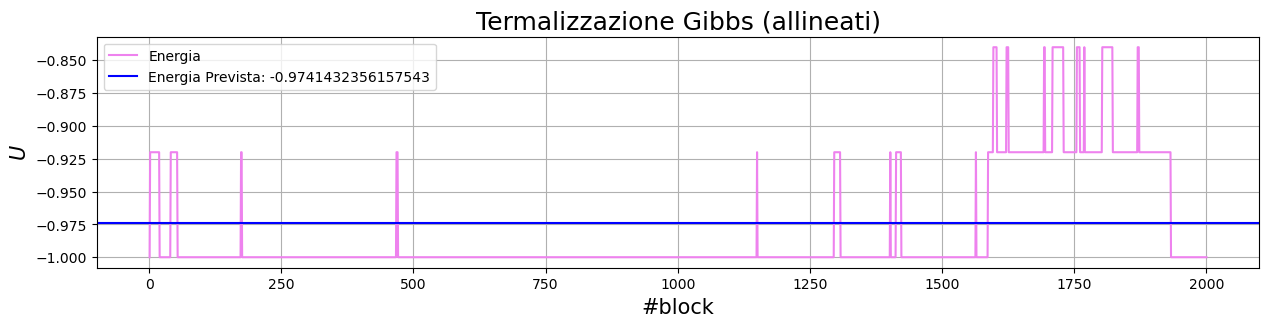

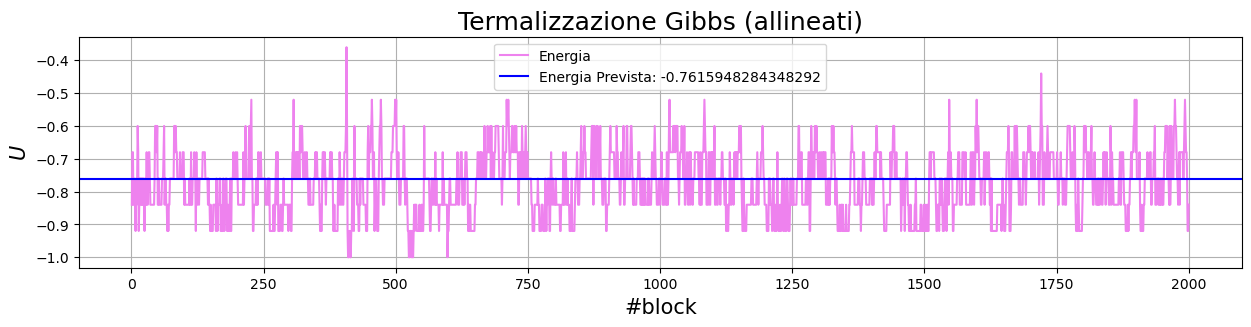

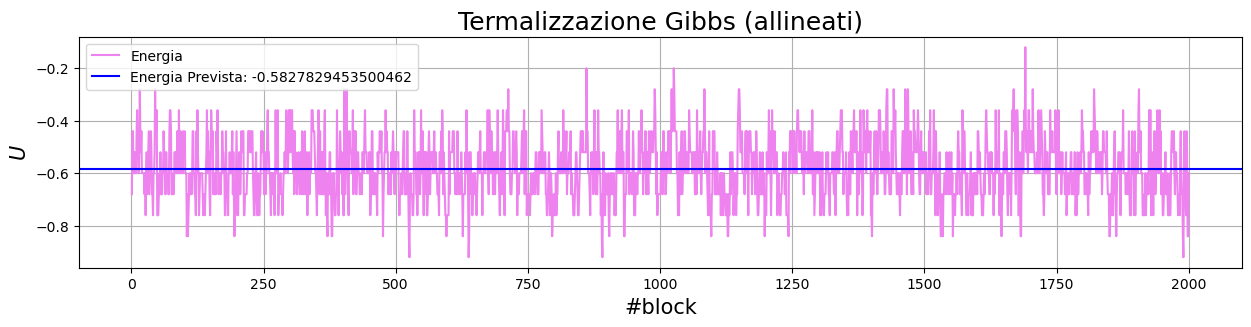

In [6]:
for i in range(0,3):
    x, aveT = np.loadtxt("Exercise06-1/output/output_thermal/gibbs/gibbs_align_"  + start[i] + ".dat", usecols=(0, 1), delimiter='\t', unpack='true')
    fig, ax = mpl.subplots(figsize=(15, 3))
    ax.plot(x, aveT, marker=None, label="Energia", color="violet")
    ax.set_title("Termalizzazione Gibbs (allineati)", fontsize=18)
    ax.set_ylabel(r'$U$', fontsize=15)
    ax.set_xlabel('#block', fontsize=15)
    ax.axhline(y=energy(T[i]), color="b", label="Energia Prevista: " + str(energy(T[i])))
    ax.grid(True)
    ax.legend()
    mpl.show()

<a id="ex-6.2"></a>
## Esercizio 6.2. - Misura delle Proprietà
Si è detto che il modello di Ising a una dimensione è risolvibile analiticamente, questo significa che per le proprietà che si andrà a misurare esiste una funzione che fornisce il valore esatto. I seguenti grafici mostrano quindi le stime delle quattro quantità comparate con il loro valore previsto dalla teoria. Per il data blocking ono stati utilizati $N=20$ blocchi da $M=10^5$ passi ciascuno. </br>
I grafici di $U, C$ e $\chi$ sono tutti calcolati nel caso di assenza di campo esterno, quindi $h = 0$, mentre per la magnetizzazione si è posto $h=0.02$

### Energia Interna

$$
\frac{U(N,T)}{N}= -J \tanh (\beta J) \Biggl( \frac{1 + \tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

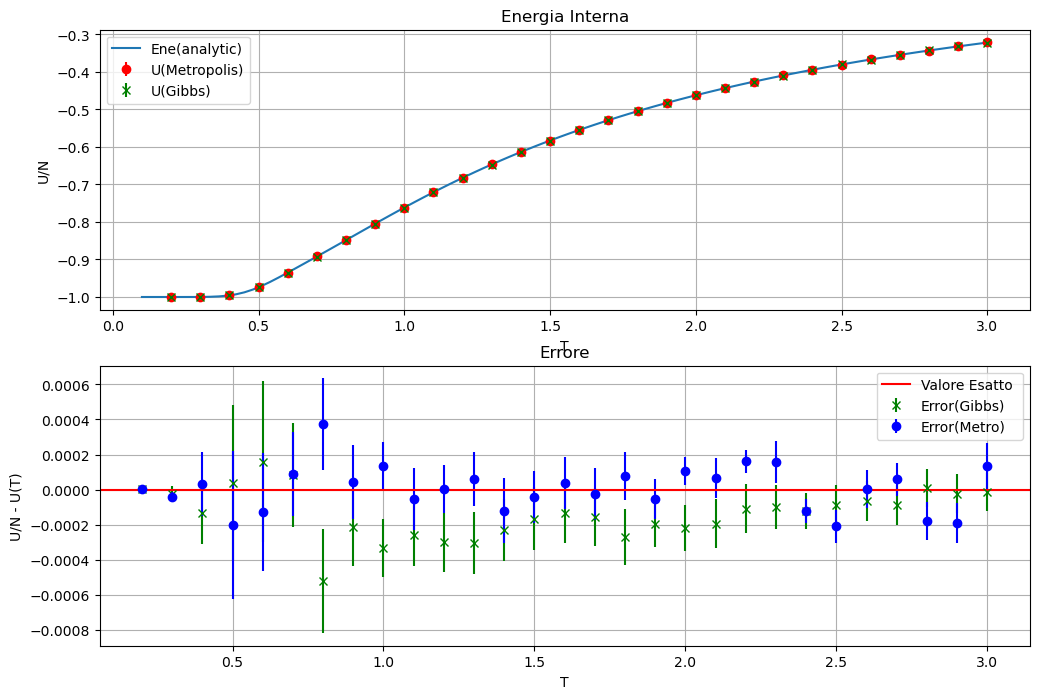

In [7]:
points=100
T = np.linspace(0.1,3.0,num=points)
beta = 1/T
J = 1.0
Ns = 50
th = np.tanh(J/T)
thN= th**Ns
ch = 1/th
e = -J*( th + ch*thN )/( 1 + thN )

mpl.figure(figsize = (12,8))

mpl.subplot(2,1,1)

mpl.plot(T, e, label="Ene(analytic)")
mpl.title('Energia Interna')
mpl.ylabel('U/N')
mpl.xlabel('T')
x, aveT, err = np.loadtxt("Exercise06-1/output/output_ene_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x, aveT, yerr = err, marker='o', linestyle="none", label="U(Metropolis)", color = "r")
x2, aveT2, err2 = np.loadtxt("Exercise06-1/output/output_ene_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x2, aveT2, yerr = err2, marker='x', linestyle="none", label="U(Gibbs)", color = "g")
mpl.legend()
mpl.grid(True)

mpl.subplot(2,1,2)
mpl.title('Errore')
mpl.ylabel('U/N - U(T)')
mpl.xlabel('T')
x3, aveT3, err3 = np.loadtxt("Exercise06-1/output/output_ene_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x3, aveT3 - energy(x3), yerr = err3, marker='x', linestyle="none", label="Error(Gibbs)", color = "g")
x4, aveT4, err4 = np.loadtxt("Exercise06-1/output/output_ene_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x4, aveT4 - energy(x4), yerr = err4, marker='o', linestyle="none", label="Error(Metro)", color = "b")
mpl.axhline(y=0, color="r", label="Valore Esatto ")
mpl.grid(True)

mpl.legend()
mpl.show()

### Capacità Termica

$$
\frac{C(N,T)}{N}= 
k_B (\beta J)^2 \left\{ 1+\tanh^N (\beta J)+(N-1)\tanh^2 (\beta J)+(N-1)\frac{\tanh^{N-2} (\beta J)}{1+\tanh^N (\beta J)}
- N \left[ \frac{\tanh (\beta J) + \tanh^{N-1} (\beta J)}{1+\tanh^N (\beta J)} \right]^2 \right\}
$$

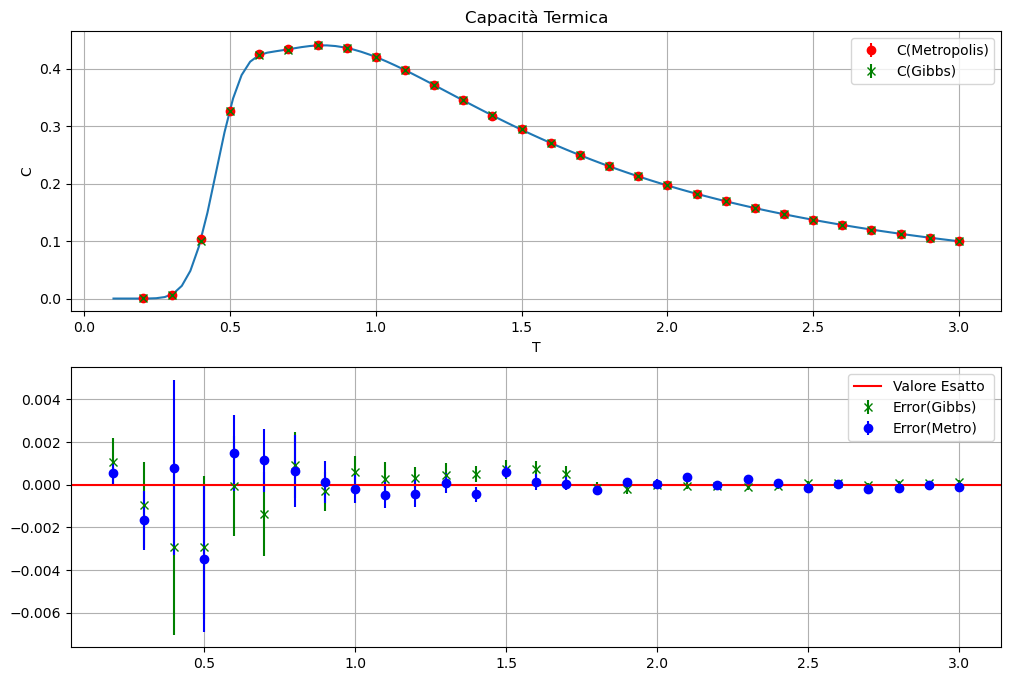

In [8]:
mpl.figure(figsize = (12,8))

mpl.subplot(2,1,1)
mpl.plot(T, heat(T))
mpl.title('Capacità Termica')
mpl.xlabel('T')
mpl.ylabel('C')
x, aveT, err = np.loadtxt("Exercise06-1/output/output_heat_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x, aveT, yerr = err, marker='o', linestyle="none", label="C(Metropolis)", color = "r")
x2, aveT2, err2 = np.loadtxt("Exercise06-1/output/output_heat_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x2, aveT2, yerr = err2, marker='x', linestyle="none", label="C(Gibbs)", color = "g")
mpl.grid(True)
mpl.legend()

mpl.subplot(2,1,2)
x3, aveT3, err3 = np.loadtxt("Exercise06-1/output/output_heat_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x3, aveT3 - heat(x3), yerr = err3, marker='x', linestyle="none", label="Error(Gibbs)", color = "g")
x4, aveT4, err4 = np.loadtxt("Exercise06-1/output/output_heat_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x4, aveT4 - heat(x4), yerr = err4, marker='o', linestyle="none", label="Error(Metro)", color = "b")
mpl.axhline(y=0, color="r", label="Valore Esatto ")
mpl.grid(True)

mpl.legend()
mpl.show()

### Suscettività Magnetica

$$
\chi(N,T) = \beta e^{2\beta J} \Biggl( \frac{1-\tanh^N (\beta J)}{1+\tanh^N (\beta J)} \Biggl)
$$

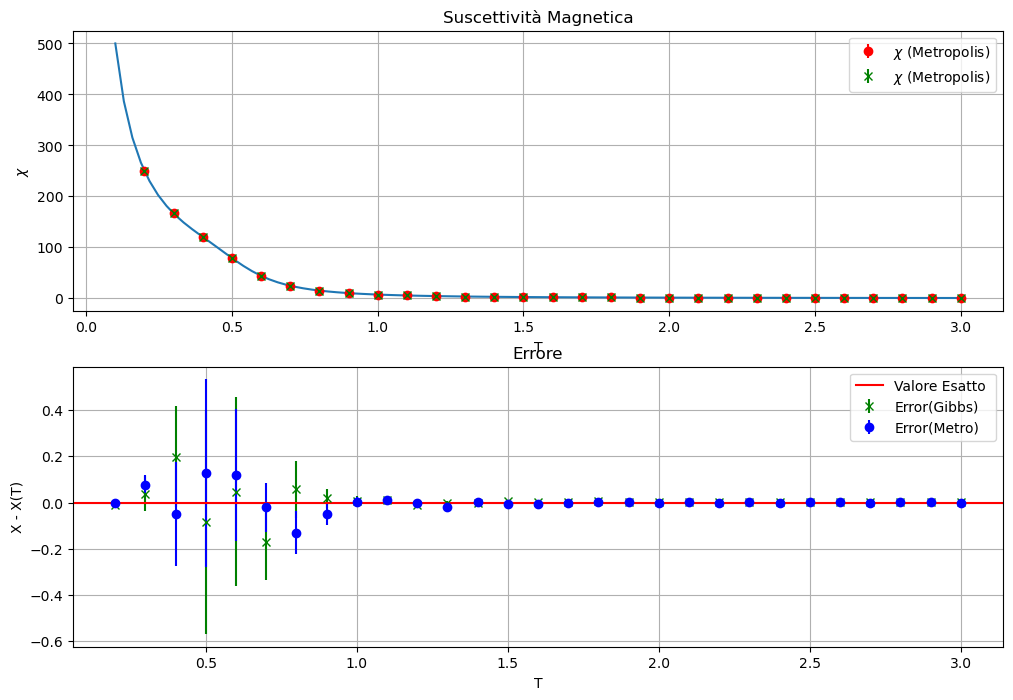

In [9]:
mpl.figure(figsize = (12,8))

mpl.subplot(2,1,1)
mpl.plot(T, chi(T))
mpl.title('Suscettività Magnetica')
mpl.xlabel('T')
mpl.ylabel('$\chi$')
x, aveT, err = np.loadtxt("Exercise06-1/output/output_chi_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x, aveT, yerr=err, marker='o', linestyle="none", label=r"$\chi$ (Metropolis)", color="r")
x2, aveT2, err2 = np.loadtxt("Exercise06-1/output/output_chi_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x2, aveT2, yerr=err2, marker='x', linestyle="none", label=r"$\chi$ (Metropolis)", color="g")
mpl.legend()
mpl.grid(True)

mpl.subplot(2,1,2)
mpl.title('Errore')
mpl.ylabel('X - X(T)')
mpl.xlabel('T')
x3, aveT3, err3 = np.loadtxt("Exercise06-1/output/output_chi_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x3, aveT3 - chi(x3), yerr = err3, marker='x', linestyle="none", label="Error(Gibbs)", color = "g")
x4, aveT4, err4 = np.loadtxt("Exercise06-1/output/output_chi_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x4, aveT4 - chi(x4), yerr = err4, marker='o', linestyle="none", label="Error(Metro)", color = "b")
mpl.axhline(y=0, color="r", label="Valore Esatto ")
mpl.grid(True)

mpl.legend()
mpl.show()

### Magnetizzazione 

$$
\frac{M(N,T,h)}{N}=\frac{e^{\beta J}\; \sinh(\beta h)}{Z} \; \Bigl[\lambda_1^{N-1}\cdot \Bigl(1+\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr) + \lambda_2^{N-1}\cdot \Bigl(1-\frac{e^{\beta J}\; \cosh(\beta h)}{\sqrt{e^{2\beta J} \cosh^2 (\beta h) - 2\sinh (2\beta J)}}\Bigr)\Bigr]
$$

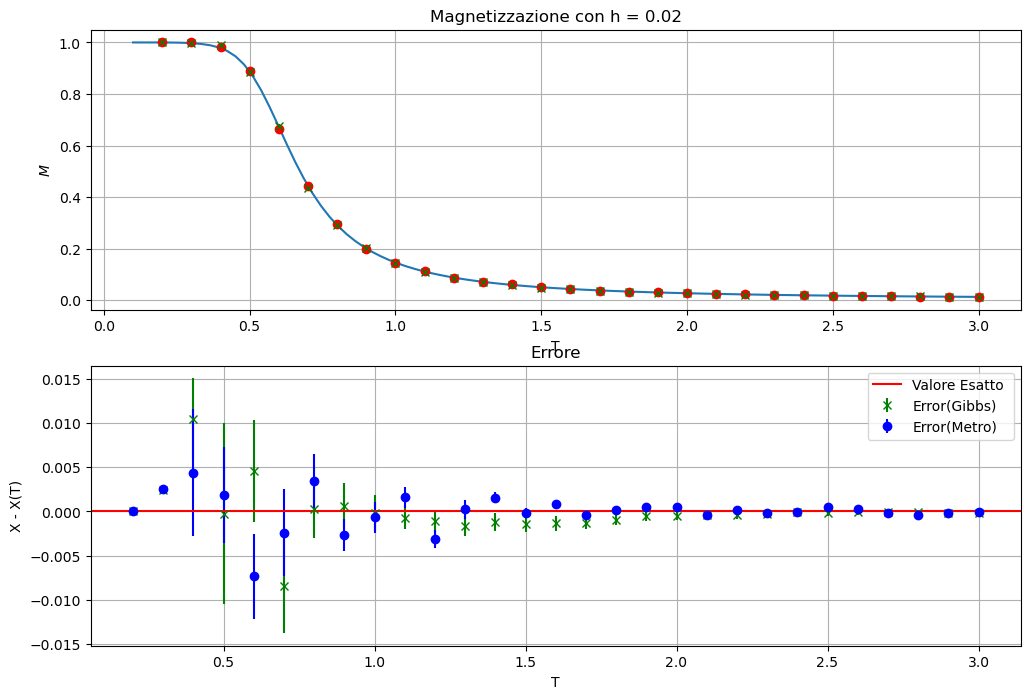

In [10]:
mpl.figure(figsize = (12,8))

mpl.subplot(2,1,1)
mpl.plot(T, mag(T))
mpl.title('Magnetizzazione con h = 0.02')
mpl.xlabel('T')
mpl.ylabel('$M$')
x, aveT, err = np.loadtxt("Exercise06-1/output/output_mag_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x, aveT, yerr=err, marker='o', linestyle="none", label=r"$\chi$ (Metropolis)", color="r")
x2, aveT2, err2 = np.loadtxt("Exercise06-1/output/output_mag_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x2, aveT2, yerr=err2, marker='x', linestyle="none", label=r"$\chi$ (Metropolis)", color="g")
mpl.grid(True)

mpl.subplot(2,1,2)
mpl.title('Errore')
mpl.ylabel('X - X(T)')
mpl.xlabel('T')
x3, aveT3, err3 = np.loadtxt("Exercise06-1/output/output_mag_gibbs.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x3, aveT3 - mag(x3), yerr = err3, marker='x', linestyle="none", label="Error(Gibbs)", color = "g")
x4, aveT4, err4 = np.loadtxt("Exercise06-1/output/output_mag_metro.dat", usecols=(0, 2, 3), delimiter=None, unpack=True)
mpl.errorbar(x4, aveT4 - mag(x4), yerr = err4, marker='o', linestyle="none", label="Error(Metro)", color = "b")
mpl.axhline(y=0, color="r", label="Valore Esatto ")
mpl.grid(True)

mpl.legend()
mpl.show()

<a id="ex-6.3"></a>
## Esercizio 6.3. - Simulazione del Sistema
I seguenti due codici, attraverso la libreria `pygame`, vogliono solo mostrare l'evoluzione del sistema a due diverse temperature, una molto bassa ($T=0.1$) e una molto alta ($T=10$). L'evoluzione è stata fatta attraverso l'algoritmo di Metropolis. Il senso di queste due animazioni è mostrare le due tendenze opposte del sistema: allineamento degli spin a basse temperature e prevalenza delle oscillazioni termiche ad alte temperature. Il file `highT.dat` contiene la simulazione ad alte temperature, `lowT.dat` quella a basse. </br>
Il codice non è ottimizzato per girare su Jupyter Lab o Github, ed in particolare potrebbero avere problemi nel chiudere la finestra alla fine del processo, mentre non hanno problemi a girare come codice Python ordinario. Per questo motivo il codice non è stato inserito nel Notebook ma è comunque visionabile nel file `spin.py`, contenuto nella cartella riferita a questa lezione.
In ogni caso, le due animazioni vengono caricate anche nella cartella dedicata a questa lezione.

In [1]:
%%HTML
<video width="640" height="480" controls>
  <source src="Exercise06-1/output/output_video/highT.mov" type="video/mp4">
</video>

In [2]:
%%HTML
<video width="640" height="480" controls>
  <source src="Exercise06-1/output/output_video/lowT.mov" type="video/mp4">
</video>